<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>

# <center>Идентификация пользователей по посещенным веб-страницам

**Импортирование требуемых библиотек**

In [148]:
import os
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import scipy.sparse
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.model_selection import learning_curve, validation_curve

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

In [96]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

## **Цели и задачи проекта, описание исходных и обработанных данных и признаков.**


**В качестве целей и задач выберем решение соревнования на Kaggle**

**Описание данных**

В обучающей выборке train_sessions.csv признаки site_i – это индексы посещенных сайтов (расшифровка дана в pickle-файле со словарем site_dic.pkl).
Признаки time_j – время посещения сайтов site_j.

Целевой признак target – факт того, что сессия принадлжит Элис (то есть что именно Элис ходила по всем этим сайтам).

**Задача – сделать прогнозы для сессий в тестовой выборке (test_sessions.csv), определить, принадлежат ли они Элис.**

**Считаем данные [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) в DataFrame train_df и test_df (обучающая и тестовая выборки)**

In [4]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'capstone_user_identification'

In [6]:
time_cols = ['time1', 'time2', 'time3', 'time4', 'time5',
             'time6', 'time7', 'time8', 'time9', 'time10']

In [7]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
                       index_col='session_id', parse_dates=time_cols)
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id', parse_dates=time_cols)

In [8]:
train_df.head(3)

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0


### Первичный анализ данных

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 1 to 253561
Data columns (total 21 columns):
site1     253561 non-null int64
time1     253561 non-null datetime64[ns]
site2     250098 non-null float64
time2     250098 non-null datetime64[ns]
site3     246919 non-null float64
time3     246919 non-null datetime64[ns]
site4     244321 non-null float64
time4     244321 non-null datetime64[ns]
site5     241829 non-null float64
time5     241829 non-null datetime64[ns]
site6     239495 non-null float64
time6     239495 non-null datetime64[ns]
site7     237297 non-null float64
time7     237297 non-null datetime64[ns]
site8     235224 non-null float64
time8     235224 non-null datetime64[ns]
site9     233084 non-null float64
time9     233084 non-null datetime64[ns]
site10    231052 non-null float64
time10    231052 non-null datetime64[ns]
target    253561 non-null int64
dtypes: datetime64[ns](10), float64(9), int64(2)
memory usage: 42.6 MB


**Отсортируем данные по времени**

In [12]:
train_df = train_df.sort_values(by="time1")

In [ ]:
**Распределение лет трейн/тест**

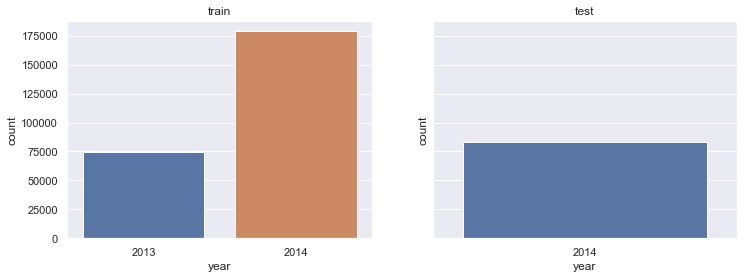

In [16]:
train_als = train_df.copy()
test_als = test_df.copy()
train_als['year'] = train_df['time1'].apply(lambda x: x.year)
test_als['year'] = test_df['time1'].apply(lambda x: x.year)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
sns.countplot(train_als['year'], ax=ax1)
ax1.set_title('train')
sns.countplot(test_als['year'], ax=ax2)
ax2.set_title('test');

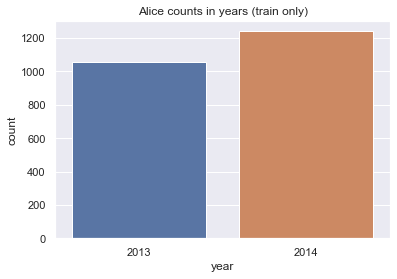

In [17]:
sns.countplot(train_als['year'][train_als['target'] == 1])
plt.title('Alice counts in years (train only)');

Видно, что выборка состоит больше из данных за 2014й год, но Элис представлена по годам примерно равномерно

**Распределение месяцев трейн/тест**

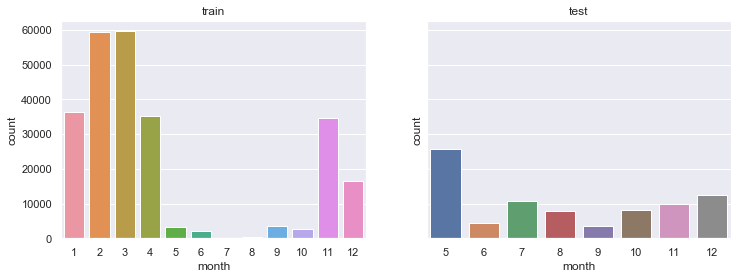

In [22]:
train_als['month'] = train_als['time1'].apply(lambda x: x.month)
test_als['month'] = test_als['time1'].apply(lambda x: x.month)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
sns.countplot(train_als['month'], ax=ax1)
ax1.set_title('train')
sns.countplot(test_als['month'], ax=ax2)
ax2.set_title('test');

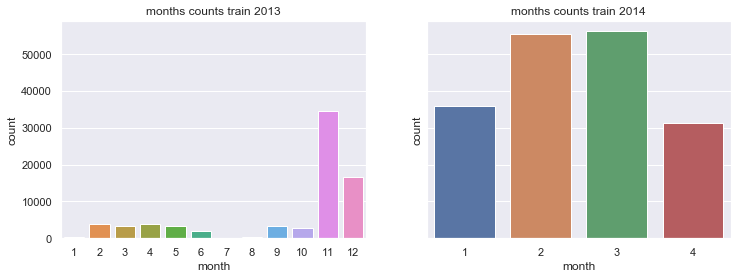

In [23]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
sns.countplot(train_als['month'][train_als['year'] == 2013], ax=ax1)
ax1.set_title('months counts train 2013')
sns.countplot(train_als['month'][train_als['year'] == 2014], ax=ax2)
ax2.set_title('months counts train 2014');

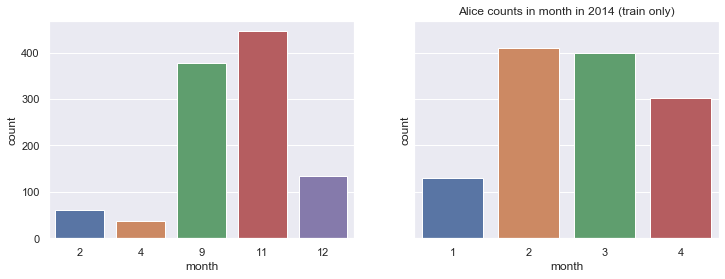

In [29]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
sns.countplot(train_als['month'][train_als['year'] == 2013][train_als['target'] == 1], ax=ax1)
plt.title('Alice counts in month in 2013 (train only)')

sns.countplot(train_als['month'][train_als['year'] == 2014][train_als['target'] == 1], ax=ax2)
plt.title('Alice counts in month in 2014 (train only)');

Видно что в 2013м Элис не пользовалась интернетом в 1м, 3м, 10м месяце и с 5го по 8й включительно, в 2014м распределение примерно равномерное, в целом это значит что мы можем добавить в качестве фичей год и месяц, и возможно это поможет идентифицировать Элис среди остальных пользователей.

**В обучающей выборке – 2297 сессий одного пользователя (Alice) и 251264 сессий – других пользователей, не Элис. Дисбаланс классов очень сильный, и смотреть на долю верных ответов (accuracy) непоказательно.**

In [33]:
train_df['target'].value_counts()

0    251264
1      2297
Name: target, dtype: int64

## **На этом с первичным анализом данных закончим, и подготовим их для обучения модели.**

In [30]:
#заполним пропуски в колонках site нулями
for i in range(1, 11):
    train_df['site{}'.format(i)] = train_df['site{}'.format(i)].fillna(0).astype('int')
for i in range(1, 11):
    test_df['site{}'.format(i)] = test_df['site{}'.format(i)].fillna(0).astype('int')

Вместо создания sparse матриц из сайтов, воспользуемся CountVectorizer и создадим кроме самих сайтов еще нграммы из них же. Набор из нграмм даст нам "признаки" того какие сайты пользователь посещает вместе, можно так же увеличить число сайтов в связке, но это не обязательно улучшит результат.

In [77]:
#Создадим датафреймы без времени для создания нграмм из сайтов
sites = ['site%s' % i for i in range(1, 11)]
sites_df_train = train_df[sites].fillna(0).astype('int')
sites_df_test = test_df[sites].fillna(0).astype('int')

In [78]:
train_list = sites_df_train.values.tolist()
train_strings = [" ".join([str(site) for site in row]) for row in train_list]

test_list = sites_df_test.values.tolist()
test_strings = [" ".join([str(site) for site in row]) for row in test_list]

In [79]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1, 3), max_features=50000) #я пробовал max_features = 100000, на паблике стало хуже
train_vectorized = vectorizer.fit_transform(train_strings)
test_vectorized = vectorizer.transform(test_strings)

Теперь на основе наших данных создадим дополнительные фичи, которые в идеале должны помочь модели отделять Элис от остальных пользователей

In [114]:
#Создаем новые фичи
# 4 фичи на время суток на начало сессии
hour = train_df['time1'].apply(lambda ts: ts.hour)
morning = ((hour >= 7) & (hour <= 11)).astype('int')
day = ((hour >= 12) & (hour <= 18)).astype('int')
evening = ((hour >= 19) & (hour <= 23)).astype('int')
night = ((hour >= 0) & (hour <= 6)).astype('int')

# Выделим месяцы посередине в которые Элис не пользовалась интернетом в фичу "лето"
month = train_df['time1'].apply(lambda ts: ts.month)
summer = ((month >= 5) & (month <= 8)).astype('int')

# добавим день недели
weekday = train_df['time1'].apply(lambda ts: ts.weekday()).astype('int')

# и год
year = train_df['time1'].apply(lambda ts: ts.year).astype('int')

# так же добавим продолжительность сессии и нормализуем её StandardScaler
times = ['time%s' % i for i in range(1, 11)]
session_duration = (train_df[times].max(axis=1) - train_df[times].min(axis=1)).astype('timedelta64[ms]').astype(int) ** 0.2
scaler = StandardScaler()
session_duration = scaler.fit_transform(session_duration.values.reshape(-1, 1)).reshape(1,-1)[0]

features_train = np.c_[morning.values, day.values, evening.values, night.values, summer.values, weekday.values, year.values, session_duration]

In [115]:
features_train_df = pd.DataFrame(features_train, columns=["morning", 'day', 'evening', 'night', 'summer', 'weekday', 'year', 'session_duration'])

In [116]:
features_train_df.head()

,morning,day,evening,night,summer,weekday,year,session_duration
0,1.0,0.0,0.0,0.0,0.0,5.0,2013.0,-2.379876
1,1.0,0.0,0.0,0.0,0.0,5.0,2013.0,2.773685
2,1.0,0.0,0.0,0.0,0.0,5.0,2013.0,-0.858827
3,1.0,0.0,0.0,0.0,0.0,5.0,2013.0,-0.943873
4,1.0,0.0,0.0,0.0,0.0,5.0,2013.0,-1.055726


По аналогии с временем дня, создадим one hot encoding на основе года и дня недели. Линейные модели модели плохо работают с категориальными признаками.

In [117]:
features_train_df = pd.get_dummies(features_train_df, columns=['weekday', 'year'], prefix=['weekday', 'year'])

In [118]:
features_train_df.head()

,morning,day,evening,night,summer,session_duration,weekday_0.0,weekday_1.0,weekday_2.0,weekday_3.0,weekday_4.0,weekday_5.0,weekday_6.0,year_2013.0,year_2014.0
0,1.0,0.0,0.0,0.0,0.0,-2.379876,0,0,0,0,0,1,0,1,0
1,1.0,0.0,0.0,0.0,0.0,2.773685,0,0,0,0,0,1,0,1,0
2,1.0,0.0,0.0,0.0,0.0,-0.858827,0,0,0,0,0,1,0,1,0
3,1.0,0.0,0.0,0.0,0.0,-0.943873,0,0,0,0,0,1,0,1,0
4,1.0,0.0,0.0,0.0,0.0,-1.055726,0,0,0,0,0,1,0,1,0


Повторим для test

In [119]:
#Создаем новые фичи для test
hour = test_df['time1'].apply(lambda ts: ts.hour)
morning = ((hour >= 7) & (hour <= 11)).astype('int')
day = ((hour >= 12) & (hour <= 18)).astype('int')
evening = ((hour >= 19) & (hour <= 23)).astype('int')
night = ((hour >= 0) & (hour <= 6)).astype('int')

month = test_df['time1'].apply(lambda ts: ts.month)
summer = ((month >= 6) & (month <= 8)).astype('int')

weekday = test_df['time1'].apply(lambda ts: ts.weekday()).astype('int')

year = test_df['time1'].apply(lambda ts: ts.year).astype('int')

times = ['time%s' % i for i in range(1, 11)]
session_duration = (test_df[times].max(axis=1) - test_df[times].min(axis=1)).astype('timedelta64[ms]').astype(int) ** 0.2
scaler = StandardScaler()
session_duration = scaler.fit_transform(session_duration.values.reshape(-1, 1)).reshape(1,-1)[0]

features_test = np.c_[morning.values, day.values, evening.values, night.values, summer.values, weekday.values, year.values, session_duration]

features_test_df = pd.DataFrame(features_test, columns=["morning", 'day', 'evening', 'night', 'summer', 'weekday', 'year', 'session_duration'])
features_test_df = pd.get_dummies(features_test_df, columns=['weekday'], prefix=['weekday'])
features_test_df['year_2013.0'] = 0
features_test_df = pd.get_dummies(features_test_df, columns=['year'], prefix=['year'])

In [120]:
features_test_df.head(3)

,morning,day,evening,night,summer,session_duration,weekday_0.0,weekday_1.0,weekday_2.0,weekday_3.0,weekday_4.0,weekday_5.0,weekday_6.0,year_2013.0,year_2014.0
0,1.0,0.0,0.0,0.0,0.0,-0.695078,0,0,0,0,0,1,0,0,1
1,1.0,0.0,0.0,0.0,1.0,0.419606,0,0,0,1,0,0,0,0,1
2,0.0,1.0,0.0,0.0,0.0,0.412902,0,0,0,0,1,0,0,0,1


**Теперь объединим результаты CountVectorizer с новым фичами и подготовим матрицы для обучения модели**

In [121]:
#Матрицы готовые для обучения
X_train = scipy.sparse.hstack([train_vectorized, features_train_df.values])
X_test = scipy.sparse.hstack([test_vectorized, features_test_df.values])
y_train = train_df["target"].astype('int').values

## **Обучим логистическую регрессию и её же через sgd и проверим на паблике в качестве бейзлайна**

In [122]:
logit = LogisticRegression(C=1, random_state=42, solver='liblinear', n_jobs=-1)
sgd_logit = SGDClassifier(loss='log', random_state=42, n_jobs=-1)

In [123]:
logit.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=42,
                   solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [124]:
logit_test_pred = logit.predict_proba(X_test)[:,1]

In [125]:
sgd_logit.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [126]:
sgd_logit_test_pred = sgd_logit.predict_proba(X_test)[:,1]

In [127]:
#write_to_submission_file(logit_test_pred, 'submit/submit_logit_final.csv') 
#0.95132 на паблике, на 5й неделе я смог получить 0.95218 отказавшись от one hot encoding.

In [128]:
#write_to_submission_file(sgd_logit_test_pred, 'submit/submit_sgd_logit_final.csv') 
#0.94781 на паблике, хуже чем регрессия, что в целом понятно, далее будем работать с логистической регрессией.

**Создадим кросс валидацию которая позволит нам валидировать без сабмитов на сайт соревнования**

Воспользуемся TimeSeriesSplit, для разбиения на трейн/валидация с учетом времени (без заглядывания трейна в будущее)
Подход описани в кернелах соревнования Юрием Кашнитским
https://inclass.kaggle.com/kashnitsky/correct-time-aware-cross-validation-scheme

In [129]:
time_split = TimeSeriesSplit(n_splits=10)

In [130]:
cv_scores = cross_val_score(logit, X_train, y_train, cv=time_split, scoring='roc_auc', n_jobs=-1)

In [131]:
cv_scores

array([0.81686824, 0.79813924, 0.91314555, 0.9842864 , 0.92995321,
       0.96257397, 0.95486674, 0.95378523, 0.87947675, 0.96080185])

In [132]:
cv_scores.mean()

0.9153897180665316

Кросс валидация показывает лучший скор ближе к последним фолдам, и низкий на первых двух, это связано с механикой работы TimeSeriesSplit, на первом фолде резмер трейна совпадаем с рамером валидейта и данных еще не хватает для хорошего прогноза.

Теперь имея более менее корректную кросс валидацию попробуем потюнить параметры моделей.

Проверим параметр С используя GridSearchCV

In [135]:
logit = LogisticRegression(C=1, random_state=42, solver='liblinear', n_jobs=-1)

In [155]:
c_values = np.logspace(-2, 2, 10)

logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={'C': c_values},
                                  scoring='roc_auc', n_jobs=-1, cv=time_split, verbose=1)

In [156]:
c_values

array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02])

In [138]:
logit_grid_searcher.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.7min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=-1, penalty='l2',
                                          random_state=42, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=Fa

In [139]:
logit_grid_searcher.best_score_, logit_grid_searcher.best_params_

(0.9173452857989748, {'C': 0.21544346900318834})

**Построим кривую валидации**

In [157]:
train_scores_val, test_scores_val = validation_curve(logit, X_train, y_train, "C", c_values, cv = time_split, scoring="roc_auc", n_jobs=-1)

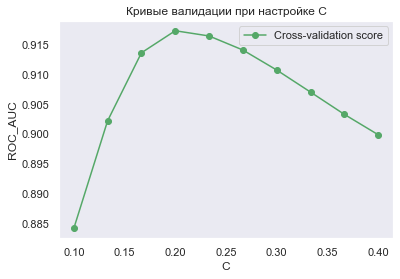

In [196]:
plt.figure()
plt.title("Кривые валидации при настройке С")
plt.xlabel("C")
plt.ylabel("ROC_AUC")
train_scores_mean = np.mean(train_scores_val, axis=1)
train_scores_std = np.std(train_scores_val, axis=1)
test_scores_mean = np.mean(test_scores_val, axis=1)
test_scores_std = np.std(test_scores_val, axis=1)
plt.grid()
plt.plot(c_values, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best");

**Попробуем еще более тонкую настройку**

In [191]:
c_values = np.linspace(0.1, 0.4, 10)

logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={'C': c_values},
                                  scoring='roc_auc', n_jobs=-1, cv=time_split, verbose=1)

In [146]:
logit_grid_searcher.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   59.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.8min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=-1, penalty='l2',
                                          random_state=42, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': array([0.1       , 0.13333333, 0.16666667, 0.2       , 0.23333333,
       0.26666667, 0.3       , 0.33333333, 0.36666667, 0.4       ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=1)

In [147]:
logit_grid_searcher.best_score_, logit_grid_searcher.best_params_

(0.9174406759344634, {'C': 0.2666666666666667})

**Построим кривую валидации для этого случая**

In [192]:
train_scores_val2, test_scores_val2 = validation_curve(logit, X_train, y_train, "C", c_values, cv = time_split, scoring="roc_auc", n_jobs=-1)

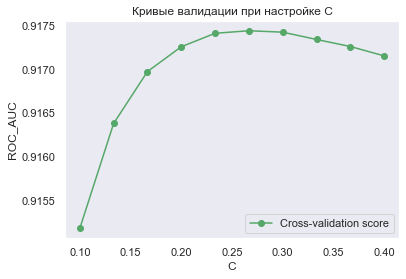

In [195]:
plt.figure()
plt.title("Кривые валидации при настройке С")
plt.xlabel("C")
plt.ylabel("ROC_AUC")
train_scores_mean = np.mean(train_scores_val2, axis=1)
train_scores_std = np.std(train_scores_val2, axis=1)
test_scores_mean = np.mean(test_scores_val2, axis=1)
test_scores_std = np.std(test_scores_val2, axis=1)
plt.grid()
plt.plot(c_values, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best");

**Построим кривую обучения**

In [188]:
train_sizes=np.linspace(.5, 1.0, 10)

In [189]:
train_sizes, train_scores, test_scores = learning_curve(
        logit, X_train, y_train, cv=time_split, n_jobs=-1, train_sizes=train_sizes, scoring='roc_auc')

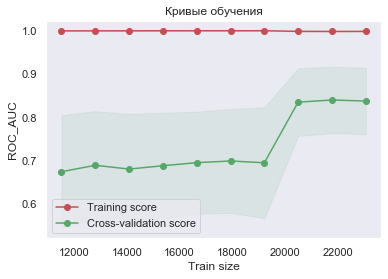

In [194]:
plt.figure()
plt.title("Кривые обучения")
plt.xlabel("Train size")
plt.ylabel("ROC_AUC")
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best");

**Видно что с ростом размера выборки растет и точность модели, то есть качество можно улучшить увеличив выборку.**

# **Обучим итоговую модель и загрузим результат на Kaggle**

In [183]:
logit = LogisticRegression(C=0.2666666666666667, random_state=42, solver='liblinear', n_jobs=-1)

In [184]:
logit.fit(X_train, y_train)

LogisticRegression(C=0.2666666666666667, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=-1, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [185]:
logit_test_pred = logit.predict_proba(X_test)[:,1]

In [186]:
write_to_submission_file(logit_test_pred, 'submit/submit_logit_final2.csv') 

Результат на паблик лидерборде получился 0.95186, что немного выше чем на не настроенной модели.
Тем не менее на 5й неделе курса я достиг результата 0.95218 не используя one hot encoding, и не проводя качественную кросс валидацию. Вполне возможно что текущее решение окажется лучше на приватной части соревнования.

# **Выводы**

Данная модель с некоторыми изменениями может служить для идентификации взломщиков по изменению паттерна поведения юзера.
Например пользователь зашел в почтовый ящик с нового компьютера - id браузера изменился, но по характеру поведения предсказываемому моделью - это тот же юзер. А если модель гооврит что этот юзер ведет себя не так как владелец, можно вывести ему требование пройти двухфакторную аутентификацию.
Для улучшения модели желательно увеличить объем данных и собрать его более однородно, так же можно создать дополнительные признаки, сделать one hot encoding по месяцам, посчитать время на каждом сайте в сессии и тд.
Так же можно продолжить настройку модели, попробовать разные солверы и регуляризаторы, попробовать другие методы классификации.